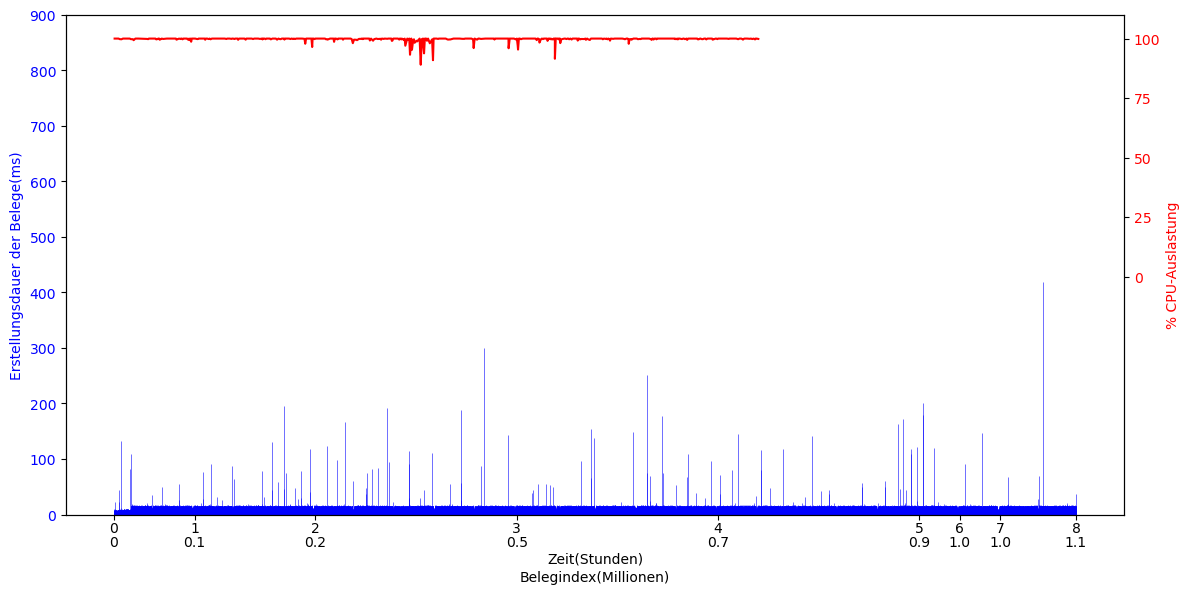

5 largest values of msb:
                            time  time_diff
21257 2024-11-27 00:53:03.698997    418.435
8405  2024-11-27 00:39:11.173781    300.157
12161 2024-11-27 00:43:14.025743    250.466
18499 2024-11-27 00:50:05.280239    201.745
3809  2024-11-27 00:34:13.940177    195.107
----------------------------------
5 smallest values in df2['BA']:
                       time      total
287 2024-11-27 00:37:36.939  89.009157
299 2024-11-27 00:37:55.205  90.915462
407 2024-11-27 00:40:56.800  91.515108
276 2024-11-27 00:37:20.983  93.213893
286 2024-11-27 00:37:36.192  93.603880


In [24]:
%matplotlib inline
import find_time_indexes
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -----------------------------------------------------------------------------------------
column = "total"
left_ax_height = 900
right_ax_buffer = 100
group_size = 50
file1 = r'D:\ba\Results\v2t1\test-cpu.csv'
file2 = r'D:\ba\Results\v2t1\test-zs.csv'
tick_times = ['2024-11-27 00:32:00', '2024-11-27 00:35:00', '2024-11-27 00:40:00']
tick_times.extend(['2024-11-27 00:45:00', '2024-11-27 00:50:00', '2024-11-27 00:51:00', '2024-11-27 00:52:00'])
# -----------------------------------------------------------------------------------------
x_axe_ticks = find_time_indexes.find(file2, tick_times)
df1 = pd.read_csv(file1, low_memory=False, encoding='utf-8')
df1['time'] = pd.to_datetime(df1['time'])
df1[column] = pd.to_numeric(df1[column], errors='coerce')  # Ensure 'value' is numeric

# Process df2 in chunks
chunksize = 1_000_000  # Adjust chunk size based on your memory capacity
time_diffs = []
times = []

for chunk in pd.read_csv(file2, usecols=['time'], chunksize=chunksize, low_memory=False):
    chunk['time'] = pd.to_datetime(chunk['time'])
    chunk['time_diff'] = chunk['time'].diff().dt.total_seconds() * 1000
    times.append(chunk['time'].iloc[1:].values)  # Skip first row since diff is NaN
    time_diffs.append(chunk['time_diff'].iloc[1:].values)  # Skip NaN diff

# Combine results from all chunks
df2 = pd.DataFrame({
    'time': pd.concat([pd.Series(t) for t in times], ignore_index=True),
    'time_diff': pd.concat([pd.Series(td) for td in time_diffs], ignore_index=True)
})

# Group df2 for plotting
df2['group'] = df2.index // group_size
df2 = df2.groupby('group').agg({'time': 'first', 'time_diff': 'max'}).reset_index(drop=True)

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 6))  # Reduce figsize to more manageable dimensions

ax1.set_xlabel('Zeit(Stunden)')
ax1.xaxis.set_label_coords(0.5, -0.075)
ax1.text(
    0.5, -0.125,                # Position: Adjust Y-coordinate to place below the main label
    "Belegindex(Millionen)",    # Text content
    color='black',               # Text color
    transform=ax1.transAxes,    # Use axes coordinates for positioning
    ha='center',                # Horizontal alignment
    va='center',                # Vertical alignment
    fontsize=10                 # Font size
)

ax1.set_ylabel('Erstellungsdauer der Belege(ms)', color='blue')
ax1.vlines(df2['time'], 0, df2['time_diff'], color='blue', label='Time Diff', linewidth=0.40)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(0, left_ax_height)

ax2 = ax1.twinx()
ax2.set_ylabel('% CPU-Auslastung', color='red')
ax2.plot(df1['time'], df1[column], color='red', label='Red Value')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(-right_ax_buffer, +110)
y_ticks = range(0, 101, 25)
ax2.set_yticks(y_ticks)

# Calculate tick positions and labels
num_rows = sum(1 for _ in open(file2, 'r', encoding='utf-8')) - 1
tick_position = [df2['time'].iloc[0]]
tick_labels_black = ["0"]
for i in range(7):
    tick_position.append(df2['time'].iloc[int(x_axe_ticks[i] / group_size)])
    tick_labels_black.append(round(x_axe_ticks[i] / 1000000, 1))
tick_position.append(df2['time'].iloc[-1])
tick_labels_black.append(round(num_rows / 1000000, 1))

# Customizing both black and red tick labels
tick_labels_red = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]

for x, black_label, red_label in zip(tick_position, tick_labels_black, tick_labels_red):
    ax1.text(
        x,               # x-coordinate
        -25,             # y-coordinate for red labels (below the black ones)
        red_label,       # Text for the red label
        color='black',     # Color of the text
        ha='center',     # Center alignment
        va='center',     # Vertical alignment
        fontsize=10       # Font size
    )
    
    # Black tick labels
    ax1.text(
        x,               # x-coordinate
        -50,             # y-coordinate for black labels
        str(black_label),# Text for the black label
        color='black',   # Color of the text
        ha='center',     # Center alignment
        va='center',     # Vertical alignment
        fontsize=10      # Font size
    )
    # Red tick labels below the black ones
    

# Remove the secondary x-axis (optional)
top_ax = ax2.secondary_xaxis('top')
top_ax.set_visible(False)

# Disable the default x-axis labels
ax2.set_xticks(tick_position)  # Set the ticks at the desired positions
ax2.set_xticklabels([])        # Remove default tick labels

fig.tight_layout()
plt.show()

# Extract top 5 values
top_5_blue = df2.nlargest(5, 'time_diff')
print("5 largest values of msb:")
print(top_5_blue)
print("----------------------------------")
top_5_red = df1.nsmallest(5, column)[['time', column]]
print("5 smallest values in df2['BA']:")
print(top_5_red)